# Load Modules

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline

## load data function

In [2]:
def load_data(file_pairs,src_dir='',dst_dir='.'):
    import os
    if not os.path.isdir(dst_dir):
        os.mkdir(dst_dir)
    for file_pair in file_pairs:
        src = os.path.abspath(os.path.expanduser(os.path.join(src_dir,file_pair[0])))
        dst = os.path.expanduser(os.path.join(dst_dir,file_pair[1]))
        if os.path.isfile(dst):
            os.remove(dst)
        if not os.path.islink(dst):
            os.symlink(src,dst)

def load_data_suffixes(file_pairs, src_dir='', dst_dir='.', suffixes=None):
    import os
    if not os.path.isdir(dst_dir):
        os.mkdir(dst_dir)
    if not suffixes:
        for file_pair in file_pairs:
            src = os.path.abspath(os.path.expanduser(os.path.join(src_dir, file_pair[0])))
            dst = os.path.expanduser(os.path.join(dst_dir, file_pair[1]))
            if os.path.isfile(dst):
                os.remove(dst)
            if not os.path.islink(dst):
                os.symlink(src, dst)
    else:
        for file_pair in file_pairs:
            for suffix_pair in suffixes:
                src = os.path.abspath(os.path.expanduser(
                    os.path.join(src_dir, file_pair[0] + suffix_pair[0])))
                dst = os.path.expanduser(
                    os.path.join(dst_dir, file_pair[1] + suffix_pair[1]))
                if os.path.isfile(dst):
                    os.remove(dst)
                if not os.path.islink(dst):
                    os.symlink(src, dst)

## venn2 function

In [3]:
def peak_overlap_venn2(peak1,
                       peak2,
                       label1='A',
                       label2='B',
                       col1='C1',
                       col2='C2',
                       col12='C12',
                       label_ha='center',
                       output_file=None):
    import subprocess
    from matplotlib_venn import venn2
    from matplotlib_venn._common import mix_colors
    from matplotlib.colors import ColorConverter
    a = int(
        subprocess.check_output(
            f'wc -l {peak1}'.split()).decode().strip().split()[0])
    b = int(
        subprocess.check_output(
            f'wc -l {peak2}'.split()).decode().strip().split()[0])
    ab = int(
        subprocess.check_output(
            f'intersectBed -u -a {peak1} -b {peak2} | wc -l',
            shell=True).decode().strip())
    ba = int(
        subprocess.check_output(
            f'intersectBed -u -a {peak2} -b {peak1} | wc -l',
            shell=True).decode().strip())
    intersect = (ab + ba) >> 1
    v = venn2((a - intersect, b - intersect, intersect),
              set_colors=(col1, col2),
              alpha=.5,
              set_labels=(label1, label2))
    v.get_label_by_id('10').set_text(f'{a-intersect:,}\n')
    v.get_label_by_id('01').set_text(f'\n{b-intersect:,}')
    v.get_label_by_id('11').set_text(f'{intersect:,}')
    v.get_patch_by_id('11').set_color(col12)
    v.get_patch_by_id('11').set_edgecolor('none')
    v.get_patch_by_id('11').set_alpha(0.4)
    
    if label_ha != 'auto' :
        for label in v.set_labels:
            label.set_ha(label_ha)
            
    if output_file:
        plt.savefig(output_file, transparent=True)
        plt.close()

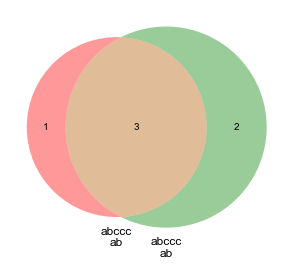

In [34]:
from matplotlib_venn import venn2
fig, ax = plt.subplots(figsize=(5,5))
v = venn2((1,2,3), set_labels=('abccc\nab', 'abccc\nab'), ax = ax)
# print(v)
# dir(v)
for label in v.set_labels:
#     print(dir(label))
    label.set_ha('center')

## box plot function

In [187]:
from seaborn.categorical import _BoxPlotter


class box_plotter(_BoxPlotter):
    def add_statistic_annotate(self, ax, x1, x2, y, h, value, text_type,
                               **kws):
        default_lw = mpl.rcParams["patch.linewidth"]
        lw = kws.get("linewidth", kws.get("lw", default_lw))
        width = x2 - x1
        x1, x2 = x1 + .1 * width, x2 - .1 * width
        ax.plot([x1, x1, x2, x2], [y + .5 * h, y + h, y + h, y + .5 * h],
                lw=1.5,
                c='k')
        if text_type == 'raw':
            ax.text((x1 + x2) * .5,
                    y + h * 1.5,
                    f'P = {value:.2e}',
                    ha='center',
                    va='bottom',
                    color='k')
        elif value >= 0.05:
            ax.text((x1 + x2) * .5,
                    y + h * 1.5,
                    'n.s.',
                    ha='center',
                    va='bottom',
                    color='k')
        elif value >= 0.01:
            ax.text((x1 + x2) * .5,
                    y + h * 1.5,
                    '*',
                    ha='center',
                    va='bottom',
                    color='k')
        elif value >= 0.001:
            ax.text((x1 + x2) * .5,
                    y_ + h * 1.5,
                    '**',
                    ha='center',
                    va='bottom',
                    color='k')
        else:
            ax.text((x1 + x2) * .5,
                    y + h * 1.5,
                    '***',
                    ha='center',
                    va='bottom',
                    color='k')

    def draw_statistic_annotate(self, ax, **kwargs):
        from operator import methodcaller
        from scipy import stats
        if kwargs.get('statistic_test') == 'mannwhitneyu':
            statistic_kwargs = {
                'use_continuity': kwargs.get('use_continuity', True),
                'alternative': kwargs.get('alternative', None)
            }
        elif kwargs.get('statistic_test') == 'wilcoxon':
            statistic_kwargs = {
                'zero_method': kwargs.get('zero_method', 'wilcox'),
                'correction': kwargs.get('correction', False),
                'alternative': kwargs.get('alternative', 'two-sided')
            }
        elif kwargs.get('statistic_test') == 'ttest_ind':
            statistic_kwargs = {
                'axis': kwargs.get('axis', 0),
                'equal_var': kwargs.get('equal_var', True),
                'nan_policy': kwargs.get('nan_policy', 'propagate')
            }
        elif kwargs.get('statistic_test') == 'ttest_rel':
            statistic_kwargs = {
                'axis': kwargs.get('axis', 0),
                'nan_policy': kwargs.get('nan_policy', 'propagate')
            }
        else:
            raise ValueError(
                'statistic_test must be either mannwhitneyu, wilcoxon, ttest_ind or ttest_rel.'
            )
        ylim = ax.get_ylim()
        h = .05 * (ylim[1] - ylim[0])
        if self.plot_hues is None:
            for i in range(len(self.plot_data) - 1):
                pvalue = methodcaller(kwargs.get('statistic_test'),
                                      self.plot_data[i], self.plot_data[i + 1],
                                      **statistic_kwargs)(stats).pvalue
                y = max(
                    mpl.cbook.boxplot_stats(self.plot_data[i])[0]['whishi'],
                    mpl.cbook.boxplot_stats(
                        self.plot_data[i + 1])[0]['whishi']) + .25 * h
                self.add_statistic_annotate(ax,
                                            i,
                                            i + 1,
                                            y,
                                            h,
                                            pvalue,
                                            text_type=kwargs.get(
                                                'text_type', 'raw'))
        else:
            for i in range(len(self.plot_data)):
                offsets = self.hue_offsets
                for j in range(len(self.hue_names) - 1):
                    pvalue = methodcaller(
                        kwargs.get('statistic_test'), self.plot_data[i][
                            self.plot_hues[i] == self.hue_names[j]],
                        self.plot_data[i][self.plot_hues[i] == self.hue_names[
                            j + 1]], **statistic_kwargs)(stats).pvalue
                    y = max(
                        mpl.cbook.boxplot_stats(
                            self.plot_data[i][self.plot_hues[i] ==
                                              self.hue_names[j]])[0]['whishi'],
                        mpl.cbook.boxplot_stats(self.plot_data[i][
                            self.plot_hues[i] == self.hue_names[j + 1]])[0]
                        ['whishi']) + .25 * h
                    self.add_statistic_annotate(ax,
                                                i + offsets[j],
                                                i + offsets[j + 1],
                                                y,
                                                h,
                                                pvalue,
                                                text_type=kwargs.get(
                                                    'text_type', 'raw'))
        ax.set_ylim(ylim[0], ylim[1] + 2.5 * h)


def boxplot(x=None,
            y=None,
            hue=None,
            data=None,
            order=None,
            hue_order=None,
            orient=None,
            color=None,
            palette=None,
            saturation=0.75,
            width=0.8,
            dodge=True,
            fliersize=5,
            linewidth=None,
            whis=1.5,
            ax=None,
            statistic_args=None,
            **kwargs):
    plotter = box_plotter(x, y, hue, data, order, hue_order, orient, color,
                          palette, saturation, width, dodge, fliersize,
                          linewidth)
    if ax is None:
        ax = plt.gca()
    kwargs.update(dict(whis=whis))
    plotter.draw_boxplot(ax, kwargs)
    plotter.annotate_axes(ax)
    if statistic_args:
        kwargs = statistic_args
        plotter.draw_statistic_annotate(ax, **kwargs)
    if plotter.orient == "h":
        ax.invert_yaxis()





## venn3 function

In [271]:
def peak_overlap_venn3(peak1,
                       peak2,
                       peak3,
                       label1='A',
                       label2='B',
                       label3='C',
                       title='Title',
                       col1='C1',
                       col2='C2',
                       col3='C3',
                       output_file=None):
    import subprocess
    from matplotlib_venn import venn3
    from matplotlib_venn._common import mix_colors
    from matplotlib.colors import ColorConverter
    a = int(
        subprocess.check_output(
            f'wc -l {peak1}'.split()).decode().strip().split()[0])
    b = int(
        subprocess.check_output(
            f'wc -l {peak2}'.split()).decode().strip().split()[0])
    c = int(
        subprocess.check_output(
            f'wc -l {peak3}'.split()).decode().strip().split()[0])
    ab = int(
        subprocess.check_output(
            f'intersectBed -u -a {peak1} -b {peak2} | wc -l',
            shell=True).decode().strip())
    ba = int(
        subprocess.check_output(
            f'intersectBed -u -a {peak2} -b {peak1} | wc -l',
            shell=True).decode().strip())
    ac = int(
        subprocess.check_output(
            f'intersectBed -u -a {peak1} -b {peak3} | wc -l',
            shell=True).decode().strip())
    ca = int(
        subprocess.check_output(
            f'intersectBed -u -a {peak3} -b {peak1} | wc -l',
            shell=True).decode().strip())
    bc = int(
        subprocess.check_output(
            f'intersectBed -u -a {peak2} -b {peak3} | wc -l',
            shell=True).decode().strip())
    cb = int(
        subprocess.check_output(
            f'intersectBed -u -a {peak3} -b {peak2} | wc -l',
            shell=True).decode().strip())
    abc = int(
        subprocess.check_output(
            f'intersectBed -u -a {peak1} -b {peak2} | intersectBed -u -a - -b {peak3} | wc -l',
            shell=True).decode().strip())
    bca = int(
        subprocess.check_output(
            f'intersectBed -u -a {peak2} -b {peak3} | intersectBed -u -a - -b {peak1} | wc -l',
            shell=True).decode().strip())
    cab = int(
        subprocess.check_output(
            f'intersectBed -u -a {peak3} -b {peak1} | intersectBed -u -a - -b {peak2} | wc -l',
            shell=True).decode().strip())
    intersect_ab = (ab + ba) >> 1
    intersect_ac = (ac + ca) >> 1
    intersect_cb = (cb + bc) >> 1
    intersect_abc = (abc + bca + cab) // 3
    print(a - intersect_ab - intersect_ac + intersect_abc,
          b - intersect_ab - intersect_cb + intersect_abc,
          intersect_ab - intersect_abc,
          c - intersect_ac - intersect_cb + intersect_abc,
          intersect_ac - intersect_abc, intersect_cb - intersect_abc,
          intersect_abc)
    v = venn3(
        (a - intersect_ab - intersect_ac + intersect_abc, b - intersect_ab -
         intersect_cb + intersect_abc, intersect_ab - intersect_abc,
         c - intersect_ac - intersect_cb + intersect_abc, intersect_ac -
         intersect_abc, intersect_cb - intersect_abc, intersect_abc),
        set_colors=(col1, col2, col3),
        alpha=.5,
        set_labels=(label1, label2, label3))
    #if a - intersect_ab - intersect_ac + intersect_abc > 0:
    #    v.get_label_by_id('100').set_text(
    #        f'{a - intersect_ab - intersect_ac + intersect_abc:,}')
    #if b - intersect_ab - intersect_cb + intersect_abc > 0:
    #    v.get_label_by_id('010').set_text(
    #        f'{b - intersect_ab - intersect_cb + intersect_abc:,}')
    #if intersect_ab - intersect_abc > 0:
    #    v.get_label_by_id('110').set_text(f'{intersect_ab - intersect_abc:,}')
    #if c - intersect_ac - intersect_cb + intersect_abc > 0:
    #    v.get_label_by_id('001').set_text(
    #        f'{c - intersect_ac - intersect_cb + intersect_abc:,}')
    #if intersect_ac - intersect_abc > 0:
    #    v.get_label_by_id('101').set_text(f'{intersect_ac - intersect_abc:,}')
    #if intersect_cb - intersect_abc > 0:
    #    v.get_label_by_id('011').set_text(f'{intersect_cb - intersect_abc:,}')
    #if intersect_abc > 0:
    #    v.get_label_by_id('111').set_text(f'{intersect_abc:,}')
    if output_file:
        plt.title(title)
        plt.savefig(output_file, transparent=True)
        plt.close()

## make_Ramp function

In [146]:
from colour import Color
from matplotlib.colors import LinearSegmentedColormap
def make_Ramp( ramp_colors ): 
    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    plt.figure( figsize = (15,3))
    plt.imshow( [list(np.arange(0, len( ramp_colors ) , 0.1)) ] , interpolation='nearest', origin='lower', cmap= color_ramp )
    plt.xticks([])
    plt.yticks([])
    return color_ramp

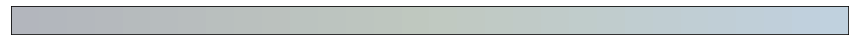

In [147]:
my_cmap_3 = make_Ramp(['#B3B6BD', '#C0C9C0', '#C0D1DF'])

## stack bar plot function

In [148]:
def stack_percentage_bar(results, horizontal=False, annotate='number'):
    import sys
    """\
    results : pandas.DataFrame
        results.index is the name of each sample.
        results.columns is the label of each category
    horizontal: bool
        If the figure should be horizontal.
    """
    # the following modules should been loaded before
    #import numpy as np
    #import matplotlib as mpl
    #mpl.rcParams['pdf.fonttype'] = 42
    #mpl.rcParams['ps.fonttype'] = 42
    #mpl.rcParams['font.sans-serif'] = 'Helvetica'
    #import matplotlib.pyplot as plt
    #import seaborn as sns
    percentage = results.div(results.sum(axis=1), axis=0) * 100
    percentage_cum = percentage.cumsum(axis=1)
    percentage_cum.loc[:, percentage_cum.shape[1] - 1] = 100.0
    category_colors = plt.get_cmap(my_cmap_3)(np.linspace(
        0.15, 0.85, results.shape[1]))
    if horizontal:
        fig, ax = plt.subplots(figsize=(6.4 * .75, 4.8))
        ax.invert_yaxis()
        ax.set_xlim(0, 100)
        for i, (category_name,
                color) in enumerate(zip(results.columns, category_colors)):
            widths = percentage.iloc[:, i]
            starts = percentage_cum.iloc[:, i] - widths
            ax.barh(results.index,
                    widths,
                    left=starts,
                    height=0.5,
                    label=category_name,
                    color=color)
            xcenters = starts + widths / 2
            r, g, b, _ = color
            text_color = 'white' if r * g * b < 0.33 else (
                'grey' if r * g * b < 0.66 else 'black')
            if annotate == 'number':
                text = [f'{x:d}' for x in results.iloc[:, i]]
            elif annotate == 'percentage':
                text = [f'{x/100:.2%}' for x in percentage.iloc[:, i]]
            else:
                sys.stdout.write(
                    f'Invalide annotate input: {annotate}. Use default parameters number.'
                )
                text = [f'{x:d}' for x in results.iloc[:, i]]
            for y, (x, c) in enumerate(zip(xcenters, text)):
                ax.text(x, y, c, ha='center', va='center', color=text_color)
        ax.set_xticks(np.arange(0, 120, 20))
        ax.set_xticklabels(np.arange(0, 120, 20))
        ax.set_xlabel('Percentage')
        ax.set_yticks(np.arange(percentage.shape[0]))
        ax.set_yticklabels(percentage.index)
        ax.set_ylabel('Sample')
        ax.legend(ncol=results.shape[1],
                  bbox_to_anchor=(0, 1),
                  loc='lower left',
                  fontsize='small')
    else:
        fig, ax = plt.subplots(figsize=(6.4 * .75, 4.8))
        ax.set_ylim(0, 100)
        for i, (category_name,
                color) in enumerate(zip(results.columns, category_colors)):
            hights = percentage.iloc[:, i]
            starts = percentage_cum.iloc[:, i] - hights
            ax.bar(results.index,
                   hights,
                   bottom=starts,
                   width=0.5,
                   label=category_name,
                   color=color)
            xcenters = starts + hights / 2
            r, g, b, _ = color
            text_color = 'white' if r * g * b < 0.33 else (
                'grey' if r * g * b < 0.66 else 'black')
            if annotate == 'number':
                text = [f'{x:d}' for x in results.iloc[:, i]]
            elif annotate == 'percentage':
                text = [f'{x/100:.2%}' for x in percentage.iloc[:, i]]
            else:
                sys.stdout.write(
                    f'Invalide annotate input: {annotate}. Use default parameters number.'
                )
                text = [f'{x:d}' for x in results.iloc[:, i]]
            for x, (c, y) in enumerate(zip(text, xcenters)):
                ax.text(x, y, c, ha='center', va='center', color=text_color)
        ax.set_xticks(np.arange(results.shape[0]))
        ax.set_xticklabels(percentage.index, rotation=45, ha='right')
        ax.set_xlabel('Sample')
        ax.set_yticks(np.arange(0, 120, 20))
        ax.set_yticklabels(np.arange(0, 120, 20))
        ax.set_ylabel('Percentage')
        ax.legend(bbox_to_anchor=(1, 0), loc='lower left')
    return fig, ax

# load data

In [6]:
import subprocess
import os
os.chdir("/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/TF/comparison")
# load samples
samples = [
    'Nanog_dome',   
    'Pou5f3_dome',
    'Sox19b_dome'
]

for sample in samples:
    file_pairs = [
        [f'{sample}_excludeIgG_filtered_peaks.narrowPeak', f'{sample}_excludeIgG_filtered_peaks.narrowPeak'],
    ]
    load_data_suffixes(file_pairs, src_dir='/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/TF/sampling_down', dst_dir='.')

In [7]:
samples = [
    'Nanog_ChIP',
    'Pou5f3_ChIP',
    'Sox19b_ChIP'
]

for sample in samples:
    file_pairs = [
        [f'{sample}_filtered_peaks.narrowPeak', f'{sample}_filtered_peaks.narrowPeak'],
    ]
    load_data_suffixes(file_pairs, src_dir='/mnt/Storage/home/wangwen/project/fitCR/analysis/comparison/sampling_down', dst_dir='.')

# FitCR v.s. ChIP-seq

## venn plot -- Fig.3C S4G S4H

In [36]:
peak_overlap_venn2('Nanog_dome_excludeIgG_filtered_peaks.narrowPeak',
                   'Nanog_ChIP_filtered_peaks.narrowPeak',
                   label1='FitCUR&RUN\npeaks',
                   label2='ChIP-seq\npeaks',
                   col1='#98BDD8',
                   col2='#E4DDC3',
                   col12='#8BB38D',
                   output_file='/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/figures/Fig3C_Venn_FitCR_ChIP_Nanog.pdf')

In [37]:
peak_overlap_venn2('Pou5f3_dome_excludeIgG_filtered_peaks.narrowPeak',
                   'Pou5f3_ChIP_filtered_peaks.narrowPeak',
                   label1='FitCUR&RUN\npeaks',
                   label2='ChIP-seq\npeaks',
                   col1='#98BDD8',
                   col2='#E4DDC3',
                   col12='#8BB38D',
                   output_file='/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/figures/Supple_Fig4G_Venn_FitCR_ChIP_Pou5f3.pdf')

In [38]:
peak_overlap_venn2('Sox19b_dome_excludeIgG_filtered_peaks.narrowPeak',
                   'Sox19b_ChIP_filtered_peaks.narrowPeak',
                   label1='FitCUR&RUN\npeaks',
                   label2='ChIP-seq\npeaks',
                   col1='#98BDD8',
                   col2='#E4DDC3',
                   col12='#8BB38D',
                   output_file='/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/figures/Supple_Fig4H_Venn_FitCR_ChIP_Sox19b.pdf')

# ATAC-seq validation

## Nanog

In [163]:
%%bash

intersectBed -v -a /mnt/Storage/home/wangwen/public_data/danRer11_2/ATAC/analysis/GR2018/atac_wt_oblong_GR2018_peaks_p10f10.bed -b Nanog_dome_excludeIgG_filtered_peaks.narrowPeak > atac_validation/atac_wt_OCR_specific_peaks.narrowPeak


In [166]:
%%bash
cd ChIP_overlap

intersectBed -v -a  ../Nanog_dome_excludeIgG_filtered_peaks.narrowPeak -b ../Nanog_ChIP_filtered_peaks.narrowPeak  >  Nanog_FitCR_specific_peaks.narrowPeak
intersectBed -v -a ../Pou5f3_dome_excludeIgG_filtered_peaks.narrowPeak -b ../Pou5f3_ChIP_filtered_peaks.narrowPeak > Pou5f3_FitCR_specific_peaks.narrowPeak
intersectBed -v -a ../Sox19b_dome_excludeIgG_filtered_peaks.narrowPeak -b ../Sox19b_ChIP_filtered_peaks.narrowPeak > Sox19b_FitCR_specific_peaks.narrowPeak


In [176]:
bw_scan = False

import subprocess


def get_bigwig_mean(bigwig_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bigwig_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold


name = 'Nanog_FitCR_specific'
capture_regions_file = 'ChIP_overlap/Nanog_FitCR_specific_peaks.narrowPeak'
bigwig_files = [
    'atat_signal/atac_wt_oblong.bw',
    'atat_signal/atac_ko_nanog_oblong.bw',
    #'atac_MO_control_GR2018.bw', 'atac_MO_nanog_GR2018.bw',
    #'atac_MO_nanog_rescue_GR2018.bw'
]
labels = [
    'wt',
    'ko',
    #'mo_control', 'mo', 'mo_resuce',
]

cmd = f'cut -f 1-4 {capture_regions_file} > atac_validation/captures_regions.bed'
subprocess.call(cmd, shell=True)

for label, bigwig_file in zip(labels, bigwig_files):
    bw_scan_cmd = f'bigWigAverageOverBed {bigwig_file} atac_validation/captures_regions.bed atac_validation/{name}_{label}_signal.tsv'
    if bw_scan:
        print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')

capture_regions = pd.read_csv('atac_validation/captures_regions.bed', sep='\t', header=None)
capture_signal_Nanog_FitCR_specific = pd.DataFrame(index=capture_regions[3].to_list())
for label, bigwig_file in zip(labels, bigwig_files):
    avg = get_bigwig_mean(bigwig_file)
    capture_signal_Nanog_FitCR_specific[label] = pd.read_csv(
        f'atac_validation/{name}_{label}_signal.tsv',
        sep='\t',
        header=None,
        index_col=0,
        names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / avg

capture_signal_Nanog_FitCR_specific


,wt,ko
Nanog_dome_peak_2,15.072308,7.910574
Nanog_dome_peak_8,14.398379,4.864855
Nanog_dome_peak_10,74.943253,23.589654
Nanog_dome_peak_29,3.066647,0.000000
Nanog_dome_peak_32,2.879665,1.888063
...,...,...
Nanog_dome_peak_42744,4.476456,2.388704
Nanog_dome_peak_42745,11.299268,3.170776
Nanog_dome_peak_42769,11.379893,7.252502
Nanog_dome_peak_42777,15.742212,4.122696


In [181]:
capture_signal_Nanog_FitCR_specific_wo0 = capture_signal_Nanog_FitCR_specific
capture_signal_Nanog_FitCR_specific_wo0 = capture_signal_Nanog_FitCR_specific_wo0.loc[~(capture_signal_Nanog_FitCR_specific_wo0[['wt','ko']]==0).any(axis=1)]
capture_signal_Nanog_FitCR_specific_wo0

,wt,ko
Nanog_dome_peak_2,15.072308,7.910574
Nanog_dome_peak_8,14.398379,4.864855
Nanog_dome_peak_10,74.943253,23.589654
Nanog_dome_peak_32,2.879665,1.888063
Nanog_dome_peak_37,165.953154,81.305036
...,...,...
Nanog_dome_peak_42744,4.476456,2.388704
Nanog_dome_peak_42745,11.299268,3.170776
Nanog_dome_peak_42769,11.379893,7.252502
Nanog_dome_peak_42777,15.742212,4.122696


In [179]:
bw_scan = False

import subprocess


def get_bigwig_mean(bigwig_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bigwig_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold


name = 'atac_OCR_specific'
capture_regions_file = 'atac_validation/atac_wt_OCR_specific_peaks.narrowPeak'
bigwig_files = [
    'atat_signal/atac_wt_oblong.bw',
    'atat_signal/atac_ko_nanog_oblong.bw',
    #'atac_MO_control_GR2018.bw', 'atac_MO_nanog_GR2018.bw',
    #'atac_MO_nanog_rescue_GR2018.bw'
]
labels = [
    'wt',
    'ko',
    #'mo_control', 'mo', 'mo_resuce',
]


cmd = f'cut -f 1-4 {capture_regions_file} > atac_validation/captures_regions.bed'
subprocess.call(cmd, shell=True)

for label, bigwig_file in zip(labels, bigwig_files):
    bw_scan_cmd = f'bigWigAverageOverBed {bigwig_file} atac_validation/captures_regions.bed atac_validation/{name}_{label}_signal.tsv'
    if bw_scan:
        print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')

capture_regions = pd.read_csv('atac_validation/captures_regions.bed', sep='\t', header=None)
capture_signal_atac_OCR_specific = pd.DataFrame(index=capture_regions[3].to_list())
for label, bigwig_file in zip(labels, bigwig_files):
    avg = get_bigwig_mean(bigwig_file)
    capture_signal_atac_OCR_specific[label] = pd.read_csv(
        f'atac_validation/{name}_{label}_signal.tsv',
        sep='\t',
        header=None,
        index_col=0,
        names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / avg

capture_signal_atac_OCR_specific


,wt,ko
MACS_peak_13,12.987309,7.974779
MACS_peak_14,6.435271,6.189370
MACS_peak_16,1.372864,3.416517
MACS_peak_20,4.224196,7.568914
MACS_peak_22,6.787824,1.716190
...,...,...
MACS_peak_77524,9.344101,5.141880
MACS_peak_77527,16.678758,13.293955
MACS_peak_77530,31.246546,6.486866
MACS_peak_77553,6.113708,4.405275


In [182]:
capture_signal_atac_OCR_specific_wo0 = capture_signal_atac_OCR_specific
capture_signal_atac_OCR_specific_wo0 = capture_signal_atac_OCR_specific_wo0.loc[~(capture_signal_atac_OCR_specific_wo0[['wt','ko']]==0).any(axis=1)]
capture_signal_atac_OCR_specific_wo0

,wt,ko
MACS_peak_13,12.987309,7.974779
MACS_peak_14,6.435271,6.189370
MACS_peak_16,1.372864,3.416517
MACS_peak_20,4.224196,7.568914
MACS_peak_22,6.787824,1.716190
...,...,...
MACS_peak_77524,9.344101,5.141880
MACS_peak_77527,16.678758,13.293955
MACS_peak_77530,31.246546,6.486866
MACS_peak_77553,6.113708,4.405275


In [180]:
bw_scan = False

import subprocess


def get_bigwig_mean(bigwig_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bigwig_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold


name = 'Nanog_FitCR_whole'
capture_regions_file = 'Nanog_dome_excludeIgG_filtered_peaks.narrowPeak'
bigwig_files = [
    'atat_signal/atac_wt_oblong.bw',
    'atat_signal/atac_ko_nanog_oblong.bw',
    #'atac_MO_control_GR2018.bw', 'atac_MO_nanog_GR2018.bw',
    #'atac_MO_nanog_rescue_GR2018.bw'
]
labels = [
    'wt',
    'ko',
    #'mo_control', 'mo', 'mo_resuce',
]


cmd = f'cut -f 1-4 {capture_regions_file} > atac_validation/captures_regions.bed'
subprocess.call(cmd, shell=True)

for label, bigwig_file in zip(labels, bigwig_files):
    bw_scan_cmd = f'bigWigAverageOverBed {bigwig_file} atac_validation/captures_regions.bed atac_validation/{name}_{label}_signal.tsv'
    if bw_scan:
        print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')

capture_regions = pd.read_csv('atac_validation/captures_regions.bed', sep='\t', header=None)
capture_signal_Nanog_FitCR_whole = pd.DataFrame(index=capture_regions[3].to_list())
for label, bigwig_file in zip(labels, bigwig_files):
    avg = get_bigwig_mean(bigwig_file)
    capture_signal_Nanog_FitCR_whole[label] = pd.read_csv(
        f'atac_validation/{name}_{label}_signal.tsv',
        sep='\t',
        header=None,
        index_col=0,
        names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / avg

capture_signal_Nanog_FitCR_whole


,wt,ko
Nanog_dome_peak_2,15.072308,7.910574
Nanog_dome_peak_5,0.000000,0.900464
Nanog_dome_peak_8,14.398379,4.864855
Nanog_dome_peak_10,74.943253,23.589654
Nanog_dome_peak_19,21.309570,2.296914
...,...,...
Nanog_dome_peak_42767,8.493977,2.617885
Nanog_dome_peak_42769,11.379893,7.252502
Nanog_dome_peak_42777,15.742212,4.122696
Nanog_dome_peak_42778,82.012020,23.686915


In [183]:
capture_signal_Nanog_FitCR_whole_wo0 = capture_signal_Nanog_FitCR_whole
capture_signal_Nanog_FitCR_whole_wo0 = capture_signal_Nanog_FitCR_whole_wo0.loc[~(capture_signal_Nanog_FitCR_whole_wo0[['wt','ko']]==0).any(axis=1)]
capture_signal_Nanog_FitCR_whole_wo0

,wt,ko
Nanog_dome_peak_2,15.072308,7.910574
Nanog_dome_peak_8,14.398379,4.864855
Nanog_dome_peak_10,74.943253,23.589654
Nanog_dome_peak_19,21.309570,2.296914
Nanog_dome_peak_23,7.064474,3.025999
...,...,...
Nanog_dome_peak_42767,8.493977,2.617885
Nanog_dome_peak_42769,11.379893,7.252502
Nanog_dome_peak_42777,15.742212,4.122696
Nanog_dome_peak_42778,82.012020,23.686915


In [185]:
plotting_data = pd.DataFrame({
    'signal':
    np.concatenate([
        np.log2(capture_signal_Nanog_FitCR_whole['ko'] + 0.000001) -
        np.log2(capture_signal_Nanog_FitCR_whole['wt'] + 0.000001),
        np.log2(capture_signal_atac_OCR_specific['ko'] + 0.000001) -
        np.log2(capture_signal_atac_OCR_specific['wt'] + 0.000001),
        np.log2(capture_signal_Nanog_FitCR_specific['ko'] + 0.000001) -
        np.log2(capture_signal_Nanog_FitCR_specific['wt'] + 0.000001),
    ]),
    'elements':
    ['Nanog FitCUT&RUN peaks'] * capture_signal_Nanog_FitCR_whole.shape[0] +
    ['accessible regions w/o Nanog binding'] *
    capture_signal_atac_OCR_specific.shape[0] +
    ['Nanog FitCUT&RUN specific peaks'] *
    capture_signal_Nanog_FitCR_specific.shape[0],
})

plotting_data

,signal,elements
0,-0.930046,Nanog FitCUT&RUN peaks
1,19.780311,Nanog FitCUT&RUN peaks
2,-1.565438,Nanog FitCUT&RUN peaks
3,-1.667644,Nanog FitCUT&RUN peaks
4,-3.213732,Nanog FitCUT&RUN peaks
...,...,...
38778,-0.906128,Nanog FitCUT&RUN specific peaks
38779,-1.833321,Nanog FitCUT&RUN specific peaks
38780,-0.649936,Nanog FitCUT&RUN specific peaks
38781,-1.932978,Nanog FitCUT&RUN specific peaks


In [184]:
plotting_data_wo0 = pd.DataFrame({
    'signal':
    np.concatenate([
        np.log2(capture_signal_Nanog_FitCR_whole_wo0['ko']) -
        np.log2(capture_signal_Nanog_FitCR_whole_wo0['wt']),
        np.log2(capture_signal_atac_OCR_specific_wo0['ko']) -
        np.log2(capture_signal_atac_OCR_specific_wo0['wt']),
        np.log2(capture_signal_Nanog_FitCR_specific_wo0['ko']) -
        np.log2(capture_signal_Nanog_FitCR_specific_wo0['wt']),
    ]),
    'elements':
    ['Nanog FitCUT&RUN peaks'] * capture_signal_Nanog_FitCR_whole_wo0.shape[0] +
    ['accessible regions w/o Nanog binding'] *
    capture_signal_atac_OCR_specific_wo0.shape[0] +
    ['Nanog FitCUT&RUN specific peaks'] *
    capture_signal_Nanog_FitCR_specific_wo0.shape[0],
})

plotting_data_wo0

,signal,elements
0,-0.930046,Nanog FitCUT&RUN peaks
1,-1.565438,Nanog FitCUT&RUN peaks
2,-1.667644,Nanog FitCUT&RUN peaks
3,-3.213732,Nanog FitCUT&RUN peaks
4,-1.223171,Nanog FitCUT&RUN peaks
...,...,...
35468,-0.906129,Nanog FitCUT&RUN specific peaks
35469,-1.833321,Nanog FitCUT&RUN specific peaks
35470,-0.649936,Nanog FitCUT&RUN specific peaks
35471,-1.932978,Nanog FitCUT&RUN specific peaks


### box plot -- Fig.3B

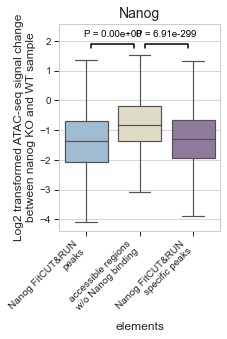

In [191]:
with sns.axes_style('whitegrid', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    fig, ax = plt.subplots(figsize=(6.4 * .5, 4.8 * 1))
    boxplot(
        x='elements',
        y='signal',
        data=plotting_data_wo0,
        palette=['#98BDD8','#E4DDC3','#9075A1'],
        showfliers=False,
        statistic_args={'statistic_test': 'mannwhitneyu',
            'use_continuity': False,},
        ax=ax,
    )
    ax.set_ylabel('Log2 transformed ATAC-seq signal change\nbetween nanog KO and WT sample')
    ax.set_xticklabels(labels=[
        'Nanog FitCUT&RUN\npeaks', 'accessible regions\nw/o Nanog binding',
        'Nanog FitCUT&RUN\nspecific peaks'
    ],
                       rotation=45, ha='right')
    ax.set_title('Nanog')
    fig.tight_layout()
    fig.savefig('/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/figures/Fig3B_boxplot_nanog_validation_ATAC_KO_VS_WT.pdf',
                transparent=True)


## Pou5f3

In [192]:
%%bash

intersectBed -v -a /mnt/Storage/home/wangwen/public_data/danRer11_2/ATAC/analysis/GR2018/atac_wt_oblong_GR2018_peaks_p10f10.bed -b Pou5f3_dome_excludeIgG_filtered_peaks.narrowPeak > atac_validation/atac_wt_OCR_specific_peaks_Pou5f3.narrowPeak


In [215]:
bw_scan = False

import subprocess


def get_bigwig_mean(bigwig_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bigwig_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold


name = 'Pou5f3_FitCR_specific'
capture_regions_file = 'ChIP_overlap/Pou5f3_FitCR_specific_peaks.narrowPeak'
bigwig_files = [
    'atat_signal/atac_wt_oblong.bw',
    'atat_signal/atac_ko_pou5f3_oblong.bw',
    #'atac_MO_control_GR2018.bw', 'atac_MO_Pou5f3_GR2018.bw',
    #'atac_MO_pou5f3_rescue_GR2018.bw'
]
labels = [
    'wt',
    'ko',
    #'mo_control', 'mo', 'mo_resuce',
]

cmd = f'cut -f 1-4 {capture_regions_file} > atac_validation/captures_regions.bed'
subprocess.call(cmd, shell=True)

for label, bigwig_file in zip(labels, bigwig_files):
    bw_scan_cmd = f'bigWigAverageOverBed {bigwig_file} atac_validation/captures_regions.bed atac_validation/{name}_{label}_signal.tsv'
    if bw_scan:
        print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')

capture_regions = pd.read_csv('atac_validation/captures_regions.bed', sep='\t', header=None)
capture_signal_Pou5f3_FitCR_specific = pd.DataFrame(index=capture_regions[3].to_list())
for label, bigwig_file in zip(labels, bigwig_files):
    avg = get_bigwig_mean(bigwig_file)
    capture_signal_Pou5f3_FitCR_specific[label] = pd.read_csv(
        f'atac_validation/{name}_{label}_signal.tsv',
        sep='\t',
        header=None,
        index_col=0,
        names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / avg

capture_signal_Pou5f3_FitCR_specific


,wt,ko
Pou5f3_dome_peak_3,7.829680,0.588321
Pou5f3_dome_peak_4,34.335006,2.537729
Pou5f3_dome_peak_5,53.455502,12.858657
Pou5f3_dome_peak_6,18.152719,46.361246
Pou5f3_dome_peak_8,27.738188,4.052400
...,...,...
Pou5f3_dome_peak_4504,47.676209,1.379697
Pou5f3_dome_peak_4508,73.364010,12.627405
Pou5f3_dome_peak_4509,53.124145,10.129001
Pou5f3_dome_peak_4510,0.413233,0.592439


In [216]:
capture_signal_Pou5f3_FitCR_specific_wo0 = capture_signal_Pou5f3_FitCR_specific
capture_signal_Pou5f3_FitCR_specific_wo0 = capture_signal_Pou5f3_FitCR_specific_wo0.loc[~(capture_signal_Pou5f3_FitCR_specific_wo0[['wt','ko']]==0).any(axis=1)]
capture_signal_Pou5f3_FitCR_specific_wo0

,wt,ko
Pou5f3_dome_peak_3,7.829680,0.588321
Pou5f3_dome_peak_4,34.335006,2.537729
Pou5f3_dome_peak_5,53.455502,12.858657
Pou5f3_dome_peak_6,18.152719,46.361246
Pou5f3_dome_peak_8,27.738188,4.052400
...,...,...
Pou5f3_dome_peak_4504,47.676209,1.379697
Pou5f3_dome_peak_4508,73.364010,12.627405
Pou5f3_dome_peak_4509,53.124145,10.129001
Pou5f3_dome_peak_4510,0.413233,0.592439


In [217]:
bw_scan = False

import subprocess


def get_bigwig_mean(bigwig_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bigwig_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold


name = 'atac_OCR_specific'
capture_regions_file = 'atac_validation/atac_wt_OCR_specific_peaks_Pou5f3.narrowPeak'
bigwig_files = [
    'atat_signal/atac_wt_oblong.bw',
    'atat_signal/atac_ko_pou5f3_oblong.bw',
    #'atac_MO_control_GR2018.bw', 'atac_MO_nanog_GR2018.bw',
    #'atac_MO_nanog_rescue_GR2018.bw'
]
labels = [
    'wt',
    'ko',
    #'mo_control', 'mo', 'mo_resuce',
]


cmd = f'cut -f 1-4 {capture_regions_file} > atac_validation/captures_regions.bed'
subprocess.call(cmd, shell=True)

for label, bigwig_file in zip(labels, bigwig_files):
    bw_scan_cmd = f'bigWigAverageOverBed {bigwig_file} atac_validation/captures_regions.bed atac_validation/{name}_{label}_signal.tsv'
    if bw_scan:
        print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')

capture_regions = pd.read_csv('atac_validation/captures_regions.bed', sep='\t', header=None)
capture_signal_atac_OCR_specific = pd.DataFrame(index=capture_regions[3].to_list())
for label, bigwig_file in zip(labels, bigwig_files):
    avg = get_bigwig_mean(bigwig_file)
    capture_signal_atac_OCR_specific[label] = pd.read_csv(
        f'atac_validation/{name}_{label}_signal.tsv',
        sep='\t',
        header=None,
        index_col=0,
        names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / avg

capture_signal_atac_OCR_specific


,wt,ko
MACS_peak_13,12.987309,12.903866
MACS_peak_14,6.435271,4.450135
MACS_peak_16,1.372864,5.289528
MACS_peak_20,4.224196,2.192909
MACS_peak_22,6.787824,5.129296
...,...,...
MACS_peak_77524,9.344101,9.518205
MACS_peak_77527,16.678758,11.626144
MACS_peak_77530,31.246546,24.047490
MACS_peak_77553,6.113708,1.552188


In [218]:
capture_signal_atac_OCR_specific_wo0 = capture_signal_atac_OCR_specific
capture_signal_atac_OCR_specific_wo0 = capture_signal_atac_OCR_specific_wo0.loc[~(capture_signal_atac_OCR_specific_wo0[['wt','ko']]==0).any(axis=1)]
capture_signal_atac_OCR_specific_wo0

,wt,ko
MACS_peak_13,12.987309,12.903866
MACS_peak_14,6.435271,4.450135
MACS_peak_16,1.372864,5.289528
MACS_peak_20,4.224196,2.192909
MACS_peak_22,6.787824,5.129296
...,...,...
MACS_peak_77524,9.344101,9.518205
MACS_peak_77527,16.678758,11.626144
MACS_peak_77530,31.246546,24.047490
MACS_peak_77553,6.113708,1.552188


In [219]:
bw_scan = False

import subprocess


def get_bigwig_mean(bigwig_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bigwig_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold


name = 'Pou5f3_FitCR_whole'
capture_regions_file = 'Pou5f3_dome_excludeIgG_filtered_peaks.narrowPeak'
bigwig_files = [
    'atat_signal/atac_wt_oblong.bw',
    'atat_signal/atac_ko_pou5f3_oblong.bw',
    #'atac_MO_control_GR2018.bw', 'atac_MO_nanog_GR2018.bw',
    #'atac_MO_nanog_rescue_GR2018.bw'
]
labels = [
    'wt',
    'ko',
    #'mo_control', 'mo', 'mo_resuce',
]


cmd = f'cut -f 1-4 {capture_regions_file} > atac_validation/captures_regions.bed'
subprocess.call(cmd, shell=True)

for label, bigwig_file in zip(labels, bigwig_files):
    bw_scan_cmd = f'bigWigAverageOverBed {bigwig_file} atac_validation/captures_regions.bed atac_validation/{name}_{label}_signal.tsv'
    if bw_scan:
        print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')

capture_regions = pd.read_csv('atac_validation/captures_regions.bed', sep='\t', header=None)
capture_signal_Pou5f3_FitCR_whole = pd.DataFrame(index=capture_regions[3].to_list())
for label, bigwig_file in zip(labels, bigwig_files):
    avg = get_bigwig_mean(bigwig_file)
    capture_signal_Pou5f3_FitCR_whole[label] = pd.read_csv(
        f'atac_validation/{name}_{label}_signal.tsv',
        sep='\t',
        header=None,
        index_col=0,
        names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / avg

capture_signal_Pou5f3_FitCR_whole


,wt,ko
Pou5f3_dome_peak_3,7.829680,0.588321
Pou5f3_dome_peak_4,34.335006,2.537729
Pou5f3_dome_peak_5,53.455502,12.858657
Pou5f3_dome_peak_6,18.152719,46.361246
Pou5f3_dome_peak_8,27.738188,4.052400
...,...,...
Pou5f3_dome_peak_4504,47.676209,1.379697
Pou5f3_dome_peak_4508,73.364010,12.627405
Pou5f3_dome_peak_4509,53.124145,10.129001
Pou5f3_dome_peak_4510,0.413233,0.592439


In [220]:
capture_signal_Pou5f3_FitCR_whole_wo0 = capture_signal_Pou5f3_FitCR_whole
capture_signal_Pou5f3_FitCR_whole_wo0 = capture_signal_Pou5f3_FitCR_whole_wo0.loc[~(capture_signal_Pou5f3_FitCR_whole_wo0[['wt','ko']]==0).any(axis=1)]
capture_signal_Pou5f3_FitCR_whole_wo0

,wt,ko
Pou5f3_dome_peak_3,7.829680,0.588321
Pou5f3_dome_peak_4,34.335006,2.537729
Pou5f3_dome_peak_5,53.455502,12.858657
Pou5f3_dome_peak_6,18.152719,46.361246
Pou5f3_dome_peak_8,27.738188,4.052400
...,...,...
Pou5f3_dome_peak_4504,47.676209,1.379697
Pou5f3_dome_peak_4508,73.364010,12.627405
Pou5f3_dome_peak_4509,53.124145,10.129001
Pou5f3_dome_peak_4510,0.413233,0.592439


In [221]:
plotting_data = pd.DataFrame({
    'signal':
    np.concatenate([
        np.log2(capture_signal_Pou5f3_FitCR_whole['ko'] + 0.000001) -
        np.log2(capture_signal_Pou5f3_FitCR_whole['wt'] + 0.000001),
        np.log2(capture_signal_atac_OCR_specific['ko'] + 0.000001) -
        np.log2(capture_signal_atac_OCR_specific['wt'] + 0.000001),
        np.log2(capture_signal_Pou5f3_FitCR_specific['ko'] + 0.000001) -
        np.log2(capture_signal_Pou5f3_FitCR_specific['wt'] + 0.000001),
    ]),
    'elements':
    ['Pou5f3 FitCUT&RUN peaks'] * capture_signal_Pou5f3_FitCR_whole.shape[0] +
    ['accessible regions w/o Pou5f3 binding'] *
    capture_signal_atac_OCR_specific.shape[0] +
    ['Pou5f3 FitCUT&RUN specific peaks'] *
    capture_signal_Pou5f3_FitCR_specific.shape[0],
})

plotting_data

,signal,elements
0,-3.734276,Pou5f3 FitCUT&RUN peaks
1,-3.758070,Pou5f3 FitCUT&RUN peaks
2,-2.055598,Pou5f3 FitCUT&RUN peaks
3,1.352734,Pou5f3 FitCUT&RUN peaks
4,-2.775025,Pou5f3 FitCUT&RUN peaks
...,...,...
19610,-5.110845,Pou5f3 FitCUT&RUN specific peaks
19611,-2.538514,Pou5f3 FitCUT&RUN specific peaks
19612,-2.390876,Pou5f3 FitCUT&RUN specific peaks
19613,0.519711,Pou5f3 FitCUT&RUN specific peaks


In [225]:
plotting_data_wo0 = pd.DataFrame({
    'signal':
    np.concatenate([
        np.log2(capture_signal_Pou5f3_FitCR_whole_wo0['ko']) -
        np.log2(capture_signal_Pou5f3_FitCR_whole_wo0['wt']),
        np.log2(capture_signal_atac_OCR_specific_wo0['ko']) -
        np.log2(capture_signal_atac_OCR_specific_wo0['wt']),
        np.log2(capture_signal_Pou5f3_FitCR_specific_wo0['ko']) -
        np.log2(capture_signal_Pou5f3_FitCR_specific_wo0['wt']),
    ]),
    'elements':
    ['Pou5f3 FitCUT&RUN peaks'] * capture_signal_Pou5f3_FitCR_whole_wo0.shape[0] +
    ['accessible regions w/o Pou5f3 binding'] *
    capture_signal_atac_OCR_specific_wo0.shape[0] +
    ['Pou5f3 FitCUT&RUN specific peaks'] *
    capture_signal_Pou5f3_FitCR_specific_wo0.shape[0],
})

plotting_data_wo0

,signal,elements
0,-3.734279,Pou5f3 FitCUT&RUN peaks
1,-3.758070,Pou5f3 FitCUT&RUN peaks
2,-2.055598,Pou5f3 FitCUT&RUN peaks
3,1.352734,Pou5f3 FitCUT&RUN peaks
4,-2.775025,Pou5f3 FitCUT&RUN peaks
...,...,...
18890,-5.110846,Pou5f3 FitCUT&RUN specific peaks
18891,-2.538514,Pou5f3 FitCUT&RUN specific peaks
18892,-2.390876,Pou5f3 FitCUT&RUN specific peaks
18893,0.519712,Pou5f3 FitCUT&RUN specific peaks


### box plot -- Fig.S4E

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


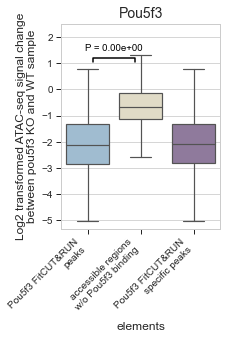

In [226]:
with sns.axes_style('whitegrid', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    fig, ax = plt.subplots(figsize=(6.4 * .5, 4.8 * 1))
    boxplot(
        x='elements',
        y='signal',
        data=plotting_data_wo0,
        palette=['#98BDD8','#E4DDC3','#9075A1'],
        showfliers=False,
        statistic_args={'statistic_test': 'mannwhitneyu',
            'use_continuity': False,},
        ax=ax,
    )
    ax.set_ylabel('Log2 transformed ATAC-seq signal change\nbetween pou5f3 KO and WT sample')
    ax.set_xticklabels(labels=[
        'Pou5f3 FitCUT&RUN\npeaks', 'accessible regions\nw/o Pou5f3 binding',
        'Pou5f3 FitCUT&RUN\nspecific peaks'
    ],
                       rotation=45, ha='right')
    ax.set_title('Pou5f3')
    fig.tight_layout()
    fig.savefig('/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/figures/Supple_Fig4E_boxplot_pou5f3_validation_ATAC_KO_VS_WT.pdf',
                transparent=True)


## Sox19b

In [204]:
%%bash

intersectBed -v -a /mnt/Storage/home/wangwen/public_data/danRer11_2/ATAC/analysis/GR2018/atac_wt_oblong_GR2018_peaks_p10f10.bed -b Sox19b_dome_excludeIgG_filtered_peaks.narrowPeak > atac_validation/atac_wt_OCR_specific_peaks_Sox19b.narrowPeak


In [205]:
bw_scan = True

import subprocess


def get_bigwig_mean(bigwig_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bigwig_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold


name = 'Sox19bg_FitCR_specific'
capture_regions_file = 'ChIP_overlap/Sox19b_FitCR_specific_peaks.narrowPeak'
bigwig_files = [
    'atat_signal/atac_wt_oblong.bw',
    'atat_signal/atac_ko_sox19b_oblong.bw',
    #'atac_MO_control_GR2018.bw', 'atac_MO_nanog_GR2018.bw',
    #'atac_MO_nanog_rescue_GR2018.bw'
]
labels = [
    'wt',
    'ko',
    #'mo_control', 'mo', 'mo_resuce',
]

cmd = f'cut -f 1-4 {capture_regions_file} > atac_validation/captures_regions.bed'
subprocess.call(cmd, shell=True)

for label, bigwig_file in zip(labels, bigwig_files):
    bw_scan_cmd = f'bigWigAverageOverBed {bigwig_file} atac_validation/captures_regions.bed atac_validation/{name}_{label}_signal.tsv'
    if bw_scan:
        print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')

capture_regions = pd.read_csv('atac_validation/captures_regions.bed', sep='\t', header=None)
capture_signal_Sox19b_FitCR_specific = pd.DataFrame(index=capture_regions[3].to_list())
for label, bigwig_file in zip(labels, bigwig_files):
    avg = get_bigwig_mean(bigwig_file)
    capture_signal_Sox19b_FitCR_specific[label] = pd.read_csv(
        f'atac_validation/{name}_{label}_signal.tsv',
        sep='\t',
        header=None,
        index_col=0,
        names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / avg

capture_signal_Sox19b_FitCR_specific


,wt,ko
Sox19b_dome_peak_4,75.242414,40.672641
Sox19b_dome_peak_5,36.987202,21.684098
Sox19b_dome_peak_15,0.158081,1.339497
Sox19b_dome_peak_18,180.248182,79.682595
Sox19b_dome_peak_22,19.533203,5.844759
...,...,...
Sox19b_dome_peak_38576,6.081216,3.279735
Sox19b_dome_peak_38579,2.683319,0.326482
Sox19b_dome_peak_38583,9.249229,1.420187
Sox19b_dome_peak_38588,8.745674,0.932344


In [206]:
capture_signal_Sox19b_FitCR_specific_wo0 = capture_signal_Sox19b_FitCR_specific
capture_signal_Sox19b_FitCR_specific_wo0 = capture_signal_Sox19b_FitCR_specific_wo0.loc[~(capture_signal_Sox19b_FitCR_specific_wo0[['wt','ko']]==0).any(axis=1)]
capture_signal_Sox19b_FitCR_specific_wo0

,wt,ko
Sox19b_dome_peak_4,75.242414,40.672641
Sox19b_dome_peak_5,36.987202,21.684098
Sox19b_dome_peak_15,0.158081,1.339497
Sox19b_dome_peak_18,180.248182,79.682595
Sox19b_dome_peak_22,19.533203,5.844759
...,...,...
Sox19b_dome_peak_38576,6.081216,3.279735
Sox19b_dome_peak_38579,2.683319,0.326482
Sox19b_dome_peak_38583,9.249229,1.420187
Sox19b_dome_peak_38588,8.745674,0.932344


In [207]:
bw_scan = True

import subprocess


def get_bigwig_mean(bigwig_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bigwig_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold


name = 'atac_OCR_specific'
capture_regions_file = 'atac_validation/atac_wt_OCR_specific_peaks_Sox19b.narrowPeak'
bigwig_files = [
    'atat_signal/atac_wt_oblong.bw',
    'atat_signal/atac_ko_sox19b_oblong.bw',
    #'atac_MO_control_GR2018.bw', 'atac_MO_nanog_GR2018.bw',
    #'atac_MO_nanog_rescue_GR2018.bw'
]
labels = [
    'wt',
    'ko',
    #'mo_control', 'mo', 'mo_resuce',
]


cmd = f'cut -f 1-4 {capture_regions_file} > atac_validation/captures_regions.bed'
subprocess.call(cmd, shell=True)

for label, bigwig_file in zip(labels, bigwig_files):
    bw_scan_cmd = f'bigWigAverageOverBed {bigwig_file} atac_validation/captures_regions.bed atac_validation/{name}_{label}_signal.tsv'
    if bw_scan:
        print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')

capture_regions = pd.read_csv('atac_validation/captures_regions.bed', sep='\t', header=None)
capture_signal_atac_OCR_specific = pd.DataFrame(index=capture_regions[3].to_list())
for label, bigwig_file in zip(labels, bigwig_files):
    avg = get_bigwig_mean(bigwig_file)
    capture_signal_atac_OCR_specific[label] = pd.read_csv(
        f'atac_validation/{name}_{label}_signal.tsv',
        sep='\t',
        header=None,
        index_col=0,
        names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / avg

capture_signal_atac_OCR_specific


,wt,ko
MACS_peak_13,12.987309,12.903866
MACS_peak_14,6.435271,4.450135
MACS_peak_16,1.372864,5.289528
MACS_peak_20,4.224196,2.192909
MACS_peak_22,6.787824,5.129296
...,...,...
MACS_peak_77524,9.344101,9.518205
MACS_peak_77527,16.678758,11.626144
MACS_peak_77530,31.246546,24.047490
MACS_peak_77553,6.113708,1.552188


In [208]:
capture_signal_atac_OCR_specific_wo0 = capture_signal_atac_OCR_specific
capture_signal_atac_OCR_specific_wo0 = capture_signal_atac_OCR_specific_wo0.loc[~(capture_signal_atac_OCR_specific_wo0[['wt','ko']]==0).any(axis=1)]
capture_signal_atac_OCR_specific_wo0

,wt,ko
MACS_peak_13,12.987309,12.903866
MACS_peak_14,6.435271,4.450135
MACS_peak_16,1.372864,5.289528
MACS_peak_20,4.224196,2.192909
MACS_peak_22,6.787824,5.129296
...,...,...
MACS_peak_77524,9.344101,9.518205
MACS_peak_77527,16.678758,11.626144
MACS_peak_77530,31.246546,24.047490
MACS_peak_77553,6.113708,1.552188


In [209]:
bw_scan = True

import subprocess


def get_bigwig_mean(bigwig_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bigwig_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold


name = 'Sox19b_FitCR_whole'
capture_regions_file = 'Sox19b_dome_excludeIgG_filtered_peaks.narrowPeak'
bigwig_files = [
    'atat_signal/atac_wt_oblong.bw',
    'atat_signal/atac_ko_sox19b_oblong.bw',
    #'atac_MO_control_GR2018.bw', 'atac_MO_nanog_GR2018.bw',
    #'atac_MO_nanog_rescue_GR2018.bw'
]
labels = [
    'wt',
    'ko',
    #'mo_control', 'mo', 'mo_resuce',
]


cmd = f'cut -f 1-4 {capture_regions_file} > atac_validation/captures_regions.bed'
subprocess.call(cmd, shell=True)

for label, bigwig_file in zip(labels, bigwig_files):
    bw_scan_cmd = f'bigWigAverageOverBed {bigwig_file} atac_validation/captures_regions.bed atac_validation/{name}_{label}_signal.tsv'
    if bw_scan:
        print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')

capture_regions = pd.read_csv('atac_validation/captures_regions.bed', sep='\t', header=None)
capture_signal_Sox19b_FitCR_whole = pd.DataFrame(index=capture_regions[3].to_list())
for label, bigwig_file in zip(labels, bigwig_files):
    avg = get_bigwig_mean(bigwig_file)
    capture_signal_Sox19b_FitCR_whole[label] = pd.read_csv(
        f'atac_validation/{name}_{label}_signal.tsv',
        sep='\t',
        header=None,
        index_col=0,
        names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / avg

capture_signal_Sox19b_FitCR_whole


,wt,ko
Sox19b_dome_peak_4,75.242414,40.672641
Sox19b_dome_peak_5,36.987202,21.684098
Sox19b_dome_peak_10,18.479971,5.727402
Sox19b_dome_peak_15,0.158081,1.339497
Sox19b_dome_peak_18,180.248182,79.682595
...,...,...
Sox19b_dome_peak_38583,9.249229,1.420187
Sox19b_dome_peak_38588,8.745674,0.932344
Sox19b_dome_peak_38591,15.072308,1.455443
Sox19b_dome_peak_38592,11.896783,4.375895


In [210]:
capture_signal_Sox19b_FitCR_whole_wo0 = capture_signal_Sox19b_FitCR_whole
capture_signal_Sox19b_FitCR_whole_wo0 = capture_signal_Sox19b_FitCR_whole_wo0.loc[~(capture_signal_Sox19b_FitCR_whole_wo0[['wt','ko']]==0).any(axis=1)]
capture_signal_Sox19b_FitCR_whole_wo0

,wt,ko
Sox19b_dome_peak_4,75.242414,40.672641
Sox19b_dome_peak_5,36.987202,21.684098
Sox19b_dome_peak_10,18.479971,5.727402
Sox19b_dome_peak_15,0.158081,1.339497
Sox19b_dome_peak_18,180.248182,79.682595
...,...,...
Sox19b_dome_peak_38583,9.249229,1.420187
Sox19b_dome_peak_38588,8.745674,0.932344
Sox19b_dome_peak_38591,15.072308,1.455443
Sox19b_dome_peak_38592,11.896783,4.375895


In [211]:
plotting_data = pd.DataFrame({
    'signal':
    np.concatenate([
        np.log2(capture_signal_Sox19b_FitCR_whole['ko'] + 0.000001) -
        np.log2(capture_signal_Sox19b_FitCR_whole['wt'] + 0.000001),
        np.log2(capture_signal_atac_OCR_specific['ko'] + 0.000001) -
        np.log2(capture_signal_atac_OCR_specific['wt'] + 0.000001),
        np.log2(capture_signal_Sox19b_FitCR_specific['ko'] + 0.000001) -
        np.log2(capture_signal_Sox19b_FitCR_specific['wt'] + 0.000001),
    ]),
    'elements':
    ['Sox19b FitCUT&RUN peaks'] * capture_signal_Sox19b_FitCR_whole.shape[0] +
    ['accessible regions w/o Sox19b binding'] *
    capture_signal_atac_OCR_specific.shape[0] +
    ['Sox19b FitCUT&RUN specific peaks'] *
    capture_signal_Sox19b_FitCR_specific.shape[0],
})

plotting_data

,signal,elements
0,-0.887487,Sox19b FitCUT&RUN peaks
1,-0.770389,Sox19b FitCUT&RUN peaks
2,-1.690010,Sox19b FitCUT&RUN peaks
3,3.082952,Sox19b FitCUT&RUN peaks
4,-1.177648,Sox19b FitCUT&RUN peaks
...,...,...
43954,-0.890780,Sox19b FitCUT&RUN specific peaks
43955,-3.038941,Sox19b FitCUT&RUN specific peaks
43956,-2.703251,Sox19b FitCUT&RUN specific peaks
43957,-3.229634,Sox19b FitCUT&RUN specific peaks


In [212]:
plotting_data_wo0 = pd.DataFrame({
    'signal':
    np.concatenate([
        np.log2(capture_signal_Sox19b_FitCR_whole_wo0['ko']) -
        np.log2(capture_signal_Sox19b_FitCR_whole_wo0['wt']),
        np.log2(capture_signal_atac_OCR_specific_wo0['ko']) -
        np.log2(capture_signal_atac_OCR_specific_wo0['wt']),
        np.log2(capture_signal_Sox19b_FitCR_specific_wo0['ko']) -
        np.log2(capture_signal_Sox19b_FitCR_specific_wo0['wt']),
    ]),
    'elements':
    ['Sox19b FitCUT&RUN peaks'] * capture_signal_Sox19b_FitCR_whole_wo0.shape[0] +
    ['accessible regions w/o Sox19b binding'] *
    capture_signal_atac_OCR_specific_wo0.shape[0] +
    ['Sox19b FitCUT&RUN specific peaks'] *
    capture_signal_Sox19b_FitCR_specific_wo0.shape[0],
})

plotting_data_wo0

,signal,elements
0,-0.887487,Sox19b FitCUT&RUN peaks
1,-0.770389,Sox19b FitCUT&RUN peaks
2,-1.690010,Sox19b FitCUT&RUN peaks
3,3.082960,Sox19b FitCUT&RUN peaks
4,-1.177648,Sox19b FitCUT&RUN peaks
...,...,...
37225,-0.890781,Sox19b FitCUT&RUN specific peaks
37226,-3.038945,Sox19b FitCUT&RUN specific peaks
37227,-2.703252,Sox19b FitCUT&RUN specific peaks
37228,-3.229635,Sox19b FitCUT&RUN specific peaks


### box plot -- Fig.S4F

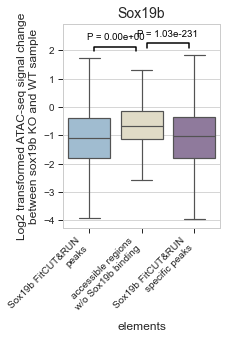

In [213]:
with sns.axes_style('whitegrid', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    fig, ax = plt.subplots(figsize=(6.4 * .5, 4.8 * 1))
    boxplot(
        x='elements',
        y='signal',
        data=plotting_data_wo0,
        palette=['#98BDD8','#E4DDC3','#9075A1'],
        showfliers=False,
        statistic_args={'statistic_test': 'mannwhitneyu',
            'use_continuity': False,},
        ax=ax,
    )
    ax.set_ylabel('Log2 transformed ATAC-seq signal change\nbetween sox19b KO and WT sample')
    ax.set_xticklabels(labels=[
        'Sox19b FitCUT&RUN\npeaks', 'accessible regions\nw/o Sox19b binding',
        'Sox19b FitCUT&RUN\nspecific peaks'
    ],
                       rotation=45, ha='right')
    ax.set_title('Sox19b')
    fig.tight_layout()
    fig.savefig('/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/figures/Supple_Fig4F_boxplot_sox19b_validation_ATAC_KO_VS_WT.pdf',
                transparent=True)


# Motif occurancy

In [137]:
os.chdir('/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/TF/comparison')

In [138]:
%%bash
cd ChIP_overlap/
ls *Peak

Nanog_ChIP_ov_dome_peaks.narrowPeak
Nanog_dome_ov_ChIP_peaks.narrowPeak
Pou5f3_ChIP_ov_dome_peaks.narrowPeak
Pou5f3_dome_ov_ChIP_peaks.narrowPeak
Sox19b_ChIP_ov_dome_peaks.narrowPeak
Sox19b_dome_ov_ChIP_peaks.narrowPeak


In [139]:
%%bash
cd motif_overlap/
ls *summits_200.bed

Nanog_ChIP_peaks_summits_200.bed
Nanog_dome_excludeIgG_peaks_summits_200.bed
Pou5f3_ChIP_peaks_summits_200.bed
Pou5f3_dome_excludeIgG_peaks_summits_200.bed
Sox19b_ChIP_peaks_summits_200.bed
Sox19b_dome_excludeIgG_peaks_summits_200.bed


In [140]:
%%bash
cd motif_overlap/
ls *peaks_ov_motif.bed


Nanog_ChIP_peaks_ov_motif.bed
Nanog_FitCR_peaks_ov_motif.bed
Pou5f3_ChIP_peaks_ov_motif.bed
Pou5f3_FitCR_peaks_ov_motif.bed
Sox19b_ChIP_peaks_ov_motif.bed
Sox19b_FitCR_peaks_ov_motif.bed


In [141]:
Nanog_ChIP_motif = pd.read_csv('motif_overlap/Nanog_ChIP_peaks_ov_motif.bed',sep='\t',header=None)
Nanog_FitCR_motif = pd.read_csv('motif_overlap/Nanog_FitCR_peaks_ov_motif.bed',sep='\t',header=None)
Pou5f3_ChIP_motif = pd.read_csv('motif_overlap/Pou5f3_ChIP_peaks_ov_motif.bed',sep='\t',header=None)
Pou5f3_FitCR_motif = pd.read_csv('motif_overlap/Pou5f3_FitCR_peaks_ov_motif.bed',sep='\t',header=None)
Sox19b_ChIP_motif = pd.read_csv('motif_overlap/Sox19b_ChIP_peaks_ov_motif.bed',sep='\t',header=None)
Sox19b_FitCR_motif = pd.read_csv('motif_overlap/Sox19b_FitCR_peaks_ov_motif.bed',sep='\t',header=None)


In [142]:
Nanog_ChIP_motif.head()

,0,1,2,3,4,5,6,7
0,chr1,12182,12382,Nanog_ChIP_peak_1,0,0,0,0
1,chr1,27672,27872,Nanog_ChIP_peak_3,0,0,0,0
2,chr1,93231,93431,Nanog_ChIP_peak_12,0,0,0,0
3,chr1,143985,144185,Nanog_ChIP_peak_18,0,0,0,0
4,chr1,580587,580787,Nanog_ChIP_peak_64,0,0,0,0


In [144]:
Nanog_ChIP_specific   = pd.read_csv('ChIP_overlap/Nanog_ChIP_ov_dome_peaks.narrowPeak',sep='\t',header=None)
Nanog_FitCR_specific  = pd.read_csv('ChIP_overlap/Nanog_dome_ov_ChIP_peaks.narrowPeak',sep='\t',header=None)
Pou5f3_ChIP_specific  = pd.read_csv('ChIP_overlap/Pou5f3_ChIP_ov_dome_peaks.narrowPeak',sep='\t',header=None)
Pou5f3_FitCR_specific = pd.read_csv('ChIP_overlap/Pou5f3_dome_ov_ChIP_peaks.narrowPeak',sep='\t',header=None)
Sox19b_ChIP_specific  = pd.read_csv('ChIP_overlap/Sox19b_ChIP_ov_dome_peaks.narrowPeak',sep='\t',header=None)
Sox19b_FitCR_specific = pd.read_csv('ChIP_overlap/Sox19b_dome_ov_ChIP_peaks.narrowPeak',sep='\t',header=None)
Nanog_ChIP_specific.head()


,0,1,2,3,4,5,6,7,8,9,10
0,chr1,12220,12425,Nanog_ChIP_peak_1,279,.,12.88220,31.86291,27.96100,63,0
1,chr1,27482,27872,Nanog_ChIP_peak_3,299,.,14.07168,33.92906,29.94839,291,0
2,chr1,93239,93489,Nanog_ChIP_peak_12,369,.,16.27170,41.24055,36.99566,93,1
3,chr1,144022,144199,Nanog_ChIP_peak_18,175,.,10.98441,20.92809,17.51555,64,0
4,chr1,580614,581027,Nanog_ChIP_peak_64,139,.,10.05215,17.20861,13.99917,74,0


In [145]:
def gen():

    titles = [
        'Nanog ChIP', 'Nanog FitCUT&RUN', 'Pou5f3 ChIP', 'Pou5f3 FitCUT&RUN',
        'Sox19b ChIP', 'Sox19b FitCUT&RUN'
    ]
    peak_motif_statuses = [
        Nanog_ChIP_motif,
        Nanog_FitCR_motif,
        Pou5f3_ChIP_motif,
        Pou5f3_FitCR_motif,
        Sox19b_ChIP_motif,
        Sox19b_FitCR_motif,
    ]
    peak_specific_statuses = [
        Nanog_ChIP_specific,
        Nanog_FitCR_specific,
        Pou5f3_ChIP_specific,
        Pou5f3_FitCR_specific,
        Sox19b_ChIP_specific,
        Sox19b_FitCR_specific,
    ]
    for title, peak_motif_status, peak_specific_status in zip(
        titles, peak_motif_statuses, peak_specific_statuses):
            motif, non_motif = 0, 0
            for (index1, row1), (index2,
                                 row2) in zip(peak_motif_status.iterrows(),
                                              peak_specific_status.iterrows()):
                if row2[10] == 0:
                    if sum(row1[4:]) > 0:
                        motif += 1
                    else:
                        non_motif += 1
            data = [motif, non_motif]
            yield non_motif, motif


motif_status = pd.DataFrame(gen(),
                            columns=['w/o motif', 'w/ motif'],
                            index=[
                                'Nanog ChIP', 'Nanog FitCUT&RUN',
                                'Pou5f3 ChIP', 'Pou5f3 FitCUT&RUN',
                                'Sox19b ChIP', 'Sox19b FitCUT&RUN'
                            ])

motif_status.head()


,w/o motif,w/ motif
Nanog ChIP,3179,709
Nanog FitCUT&RUN,7467,2414
Pou5f3 ChIP,37,62
Pou5f3 FitCUT&RUN,381,899
Sox19b ChIP,124,89


In [162]:
def gen():

    titles = [
        'Nanog ChIP', 'Nanog FitCUT&RUN', 'Pou5f3 ChIP', 'Pou5f3 FitCUT&RUN',
        'Sox19b ChIP', 'Sox19b FitCUT&RUN'
    ]
    peak_motif_statuses = [
        Nanog_ChIP_motif,
        Nanog_FitCR_motif,
        Pou5f3_ChIP_motif,
        Pou5f3_FitCR_motif,
        Sox19b_ChIP_motif,
        Sox19b_FitCR_motif,
    ]
    peak_specific_statuses = [
        Nanog_ChIP_specific,
        Nanog_FitCR_specific,
        Pou5f3_ChIP_specific,
        Pou5f3_FitCR_specific,
        Sox19b_ChIP_specific,
        Sox19b_FitCR_specific,
    ]
    for title, peak_motif_status, peak_specific_status in zip(
        titles, peak_motif_statuses, peak_specific_statuses):
            motif, non_motif = 0, 0
            for (index1, row1), (index2,
                                 row2) in zip(peak_motif_status.iterrows(),
                                              peak_specific_status.iterrows()):
                if row2[10] == 0:
                    if sum(row1[4:]) > 0:
                        motif += 1
                    else:
                        non_motif += 1
            data = [motif, non_motif]
            TF, method = title.split()
            yield 100 * motif / (motif + non_motif), TF, method


motif_status = pd.DataFrame(
    gen(),
    columns=['Percentage', 'TF', 'method'],
)

motif_status.head()


,Percentage,TF,method
0,18.235597,Nanog,ChIP
1,24.430726,Nanog,FitCUT&RUN
2,62.626263,Pou5f3,ChIP
3,70.234375,Pou5f3,FitCUT&RUN
4,41.784038,Sox19b,ChIP


## bar plot -- Fig.3D

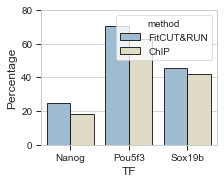

In [160]:
with sns.axes_style('whitegrid', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    fig, ax = plt.subplots(figsize=(6.4 * .5, 4.8 * .55))
    sns.barplot(
        x='TF',
        y='Percentage',
        hue='method',
        data=motif_status,
        hue_order=['FitCUT&RUN', 'ChIP'],
        palette=['#98BDD8', '#E4DDC3'],
        edgecolor='black',
        ax=ax,
    )
    ax.set_ylim(0,80)
    fig.tight_layout()
    fig.savefig('/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/figures/Fig3D_barplot_motif_occurrence.pdf', transparent=True)
    

# Moderate enrichment

In [261]:
os.chdir('/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/TF/comparison')

In [267]:
def get_bigwig_mean(bw_file):
    import os
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bw_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold


def comparsion(factor, palette):
    # heatmap
    import subprocess
    cmd = f'''\
cat {factor}_dome_excludeIgG_filtered_peaks.narrowPeak {factor}_ChIP_filtered_peaks.narrowPeak | cut -f 1-3 | sort -k1,1 -k2,2n | mergeBed -i - > ChIP_overlap/{factor}_merged_peaks.bed
intersectBed -c -a ChIP_overlap/{factor}_merged_peaks.bed -b {factor}_dome_excludeIgG_filtered_peaks.narrowPeak | intersectBed -c -a - -b {factor}_ChIP_filtered_peaks.narrowPeak > ChIP_overlap/{factor}_merged_peaks_ov_FitCR_ChIP.bed
'''
    subprocess.call(cmd, shell=True)

    import os
    import subprocess

    resolution = 50
    span = 2000
    capture_points = 2 * span // resolution + 1
    xticks = np.arange(-span, span + resolution, resolution)
    bigwig_files = [f'/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/TF/comparison/bigWig/{factor}_dome.bw', f'/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/TF/comparison/bigWig/{factor}_ChIP.bw']
    labels = ['FitCUT&RUN', 'ChIP']
    ov_status = pd.read_csv(
        f'ChIP_overlap/{factor}_merged_peaks_ov_FitCR_ChIP.bed',
        sep='\t',
        header=None)
    FitCR_specific = [
        True if x > 0 and y == 0 else False
        for x, y in zip(ov_status[3], ov_status[4])
    ]
    ENCODE_specific = [
        True if x == 0 and y > 0 else False
        for x, y in zip(ov_status[3], ov_status[4])
    ]
    both = [
        True if x > 0 and y > 0 else False
        for x, y in zip(ov_status[3], ov_status[4])
    ]
    peak_group = [FitCR_specific, both, ENCODE_specific]
    
    cmd = f'randomBed -l 1 -n {ov_status.shape[0]} -g ~wangwen/source/bySpecies/danRer11_2/danRer11_2_main.chrom.sizes > ChIP_overlap/{factor}_control.bed'
    subprocess.call(cmd, shell=True)
    factor_control = pd.read_csv(f'ChIP_overlap/{factor}_control.bed',
                                 sep='\t',
                                 header=None)
    # line
    with open(f'ChIP_overlap/{factor}_control_len.bed', 'w') as fhd1, \
         open(f'ChIP_overlap/capture_regions.bed', 'w') as fhd2:
        for (index1, row1), (index2, row2) in zip(ov_status.iterrows(),
                                                  factor_control.iterrows()):
            length = row1[2] - row1[1]
            fhd1.write(
                f'{row2[0]}\t{row2[1]-(length>>1)}\t{row2[1]+(length>>1)}\n')
            fhd2.write(
                f'{row2[0]}\t{row2[1]-span-(resolution>>1)}\t{row2[1]+span+(resolution>>1)+1}\n'
            )

    os.chdir('ChIP_overlap')
    name = f'{factor}_peak_mean'
    capture_regions_file = f'{factor}_merged_peaks_ov_FitCR_ChIP.bed'
    bw_scan_cmd = f'/mnt/Storage/home/wangyiman/bin/utilities/getBigWigValue.py -n {name} -p 8 -s 1 -m speed -b {capture_regions_file}'
    for bigwig_file in bigwig_files:
        bw_scan_cmd += f' -w {bigwig_file}'
    print(bw_scan_cmd)
    subprocess.call(bw_scan_cmd, shell=True)
    factor_peak_mean_signal = {}
    factor_peak_mean_signal['peak'] = {}
    for index, (bigwig_file, label) in enumerate(zip(bigwig_files, labels)):
        mean = get_bigwig_mean(bigwig_file)
        factor_peak_mean_signal['peak'][label] = pd.read_csv(
            f'signal_{name}_siteprof{index+1}.gz',
            sep='\t',
            header=None,
            index_col=None) / mean

    name = f'{factor}_peak_control_mean'
    capture_regions_file = f'{factor}_control_len.bed'
    bw_scan_cmd = f'/mnt/Storage/home/wangyiman/bin/utilities/getBigWigValue.py -n {name} -p 8 -s 1 -m speed -b {capture_regions_file}'
    for bigwig_file in bigwig_files:
        bw_scan_cmd += f' -w {bigwig_file}'
    subprocess.call(bw_scan_cmd, shell=True)

    factor_peak_mean_signal['control'] = {}
    for index, (bigwig_file, label) in enumerate(zip(bigwig_files, labels)):
        mean = get_bigwig_mean(bigwig_file)
        factor_peak_mean_signal['control'][label] = pd.read_csv(
            f'signal_{name}_siteprof{index+1}.gz',
            sep='\t',
            header=None,
            index_col=None) / mean
    os.chdir('..')

    plotting_data = pd.DataFrame({
        'signal':
        np.concatenate(
            (factor_peak_mean_signal['peak'][labels[1]][peak_group[0]][0],
             factor_peak_mean_signal['control'][labels[1]][peak_group[0]][0])),
        'label': ['FitCUT&RUN specific peaks'] *
        factor_peak_mean_signal['peak'][labels[1]][peak_group[0]].shape[0] +
        ['random control regions'] *
        factor_peak_mean_signal['control'][labels[1]][peak_group[0]].shape[0]
    })
    with sns.axes_style('whitegrid', rc={
            'xtick.bottom': True,
            'ytick.left': True
    }), sns.plotting_context('paper',
                             rc={
                                 'axes.titlesize': 12,
                                 'axes.labelsize': 10
                             }):
        fig, ax = plt.subplots(figsize=(6.4 * .5, 4.8))
        boxplot(
            y='signal',
            x='label',
            data=plotting_data,
            palette=palette,
            showfliers=False,
            statistic_args={
                'statistic_test': 'mannwhitneyu',
                'use_continuity': False
            },
            ax=ax,
        )
        ax.set_ylabel('Fold of ChIP-seq signal')
        ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
        fig.tight_layout()
        if factor == 'Nanog' :
            fig_name = 'Fig3E'
        elif factor == 'Pou5f3' :
            fig_name = 'Supple_Fig4I'
        else :
            fig_name = 'Supple_Fig4J'
        fig.savefig(f'/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/figures/{fig_name}_boxplot_{factor}_FitCR_specific_peaks.pdf',
                    transparent=True)


## Nanog

### box plot -- Fig.3E

/mnt/Storage/home/wangyiman/bin/utilities/getBigWigValue.py -n Nanog_peak_mean -p 8 -s 1 -m speed -b Nanog_merged_peaks_ov_FitCR_ChIP.bed -w /mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/TF/comparison/bigWig/Nanog_dome.bw -w /mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/TF/comparison/bigWig/Nanog_ChIP.bw


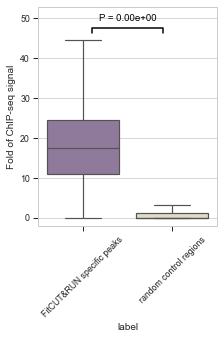

In [268]:
comparsion('Nanog',['#9075A1','#E4DDC3'])

## Pou5f3

### box plot -- Fig.S4I

/mnt/Storage/home/wangyiman/bin/utilities/getBigWigValue.py -n Pou5f3_peak_mean -p 8 -s 1 -m speed -b Pou5f3_merged_peaks_ov_FitCR_ChIP.bed -w /mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/TF/comparison/bigWig/Pou5f3_dome.bw -w /mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/TF/comparison/bigWig/Pou5f3_ChIP.bw


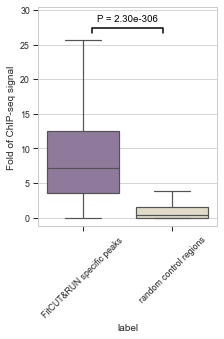

In [269]:
comparsion('Pou5f3',['#9075A1','#E4DDC3'])

## Sox19b

### box plot -- Fig.S4J

/mnt/Storage/home/wangyiman/bin/utilities/getBigWigValue.py -n Sox19b_peak_mean -p 8 -s 1 -m speed -b Sox19b_merged_peaks_ov_FitCR_ChIP.bed -w /mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/TF/comparison/bigWig/Sox19b_dome.bw -w /mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/TF/comparison/bigWig/Sox19b_ChIP.bw


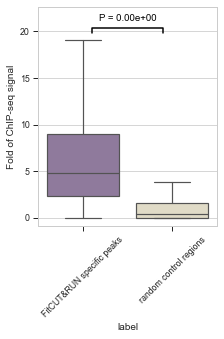

In [270]:
comparsion('Sox19b',['#9075A1','#E4DDC3'])